# Customer Churn Analysis

This notebook is using customer churn data from Kaggle (https://www.kaggle.com/sandipdatta/customer-churn-analysis) and has been adopted from the notebook available on Kaggle developed by SanD.

The notebook will go through the following steps:
    1. Import Dataset
    2. Analyze the Data
    3. Prepare the data model building
    4. Split data in test and train data
    5. Train model using various machine learning algorithms for binary classification
    6. Evaluate the models
    7. Select the model best fit for the given data set
    8. Save and deploy model to Watson Machine Learning

In [78]:
from sklearn import model_selection
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

In [79]:
%matplotlib inline 

from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
import json

## Dataset

The original dataset can be downloaded from https://www.kaggle.com/becksddf/churn-in-telecoms-dataset/data. Then upload it to IBM Watson Studio and insert the code to read the data using "insert to code > Insert panndas DataFrame".

In [80]:
# @hidden cell
# Click the 1001 data icon at the upper part of the page to open the Files subpanel. 
# In the right part of the page, select the Customer Churn .csv data set. Click insert to code, and select Insert pandas DataFrame.# @hidden_cell# @hidden_cell

from project_lib import Project
project = Project.access()

DB2_metadata = project.get_connection(name="DB2")

import os, jaydebeapi, pandas as pd

DB2_url = 'jdbc:db2://{}:{}/{}'.format(
    DB2_metadata['host'],
    DB2_metadata.get('port', 50000),
    DB2_metadata['database']
)

DB2_connection = jaydebeapi.connect(
    'com.ibm.db2.jcc.DB2Driver',
    DB2_url,
    [DB2_metadata['username'],DB2_metadata['password']]
)
   
query = 'SELECT * FROM "DEMODATA"."CUST_CHURN"'
data_df_2 = pd.read_sql_query(query, con=DB2_connection)
data_df_2.head()

# After use, close the database connection with the following code:
DB2_connection.close()
# make sure you assign the dataframe to the variable "df"
df = data_df_2
print (df.shape)

(3333, 21)


Examine the first 5 lines of the input

In [81]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
2,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
3,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0
4,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0


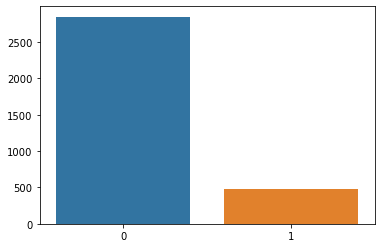

In [82]:
y = df["churn"].value_counts()
sns.barplot(y.index, y.values)

In [83]:
y_True = df["churn"][df["churn"] == True]

print ("Churn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 )+"%")

Churn Percentage = 14.491449144914492%


## Descriptive Analysis of the Data

In [84]:
  df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


### Churn by State 

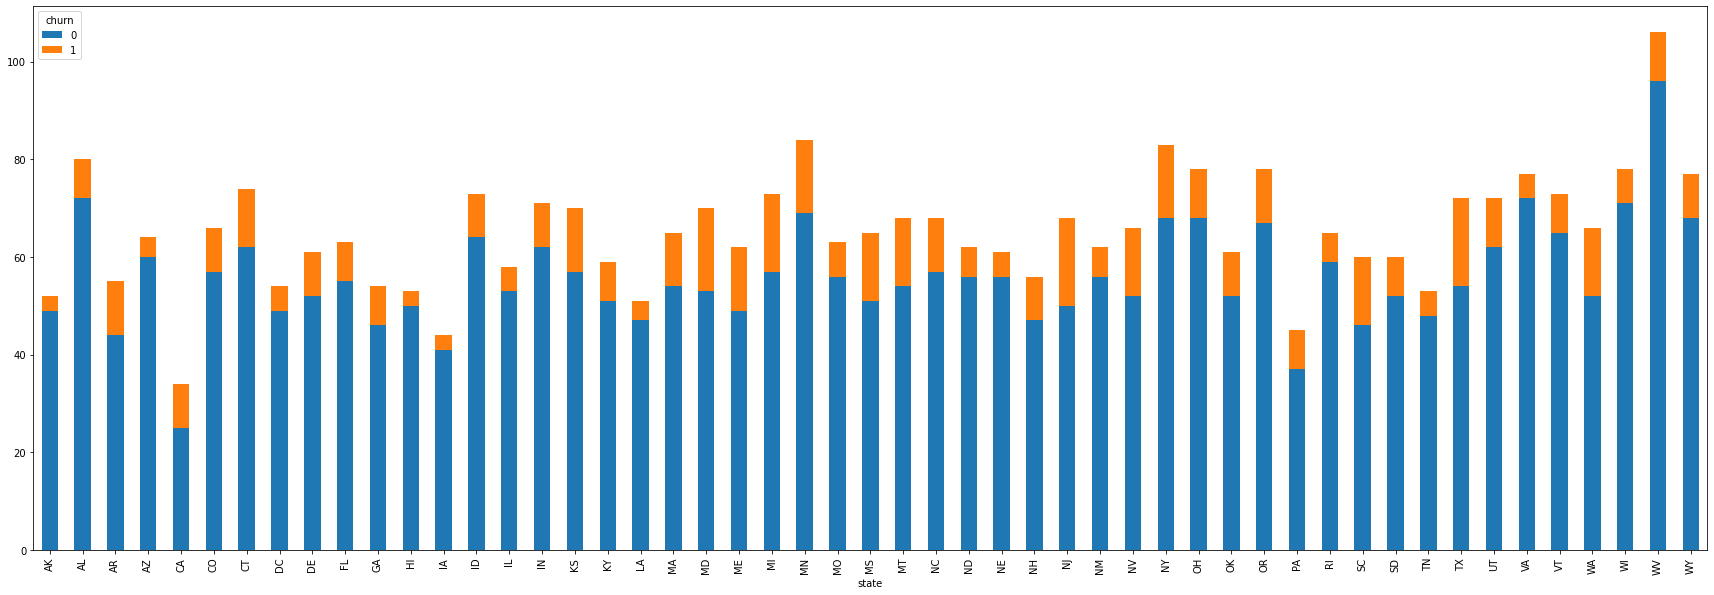

In [85]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

### Churn by Area Code 

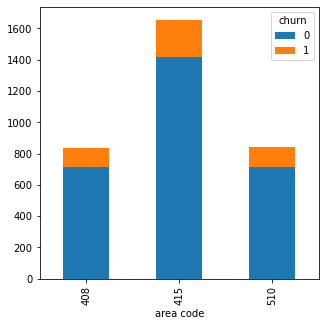

In [86]:
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

###  Churn by customers with International Plan 

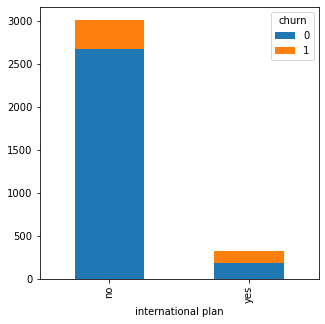

In [87]:
df.groupby(["international plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

### Churn By Customers with Voice mail plan

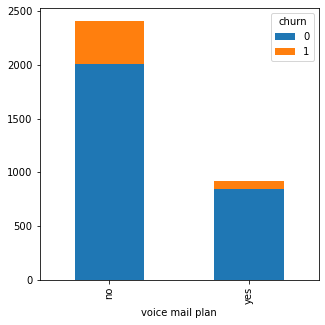

In [88]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

## Data Preparation

The following preprocessing steps need to be done:
1. Turn categorical variables into discrete numerical variables
2. Create response vector
3. Drop superflous columns
4. Build feature matrix
5. Standardize feature matrix values

### Encode categorical columns

In [89]:
# Discreet value integer encoder
label_encoder = preprocessing.LabelEncoder()

# State, international plans and voice mail plan are strings and we want discreet integer values
df['state'] = label_encoder.fit_transform(df['state'])
df['international plan'] = label_encoder.fit_transform(df['international plan'])
df['voice mail plan'] = label_encoder.fit_transform(df['voice mail plan'])
df['churn']=df['churn'].values.astype(bool)
print (df.dtypes)

state                       int64
account length              int64
area code                   int64
phone number               object
international plan          int64
voice mail plan             int64
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object


In [90]:
print (df.shape)
df.head()

(3333, 21)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,35,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
1,35,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
2,1,118,510,391-8027,1,0,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
3,18,117,408,335-4719,0,0,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
4,49,141,415,330-8173,1,1,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


### Create response vector

In [91]:
y = df['churn'].values.astype(np.int)
y.size

3333

In [92]:
# write shaped dataset to database
DB2_metadata = project.get_connection(name="DB2")
dsn = 'DASHDB;Database={};Hostname={};Port={};PROTOCOL=TCPIP;UID={};PWD={}'.format(
    DB2_metadata['database'],
    DB2_metadata['host'],
    DB2_metadata.get('port',50000),
    DB2_metadata['username'],
    DB2_metadata['password']
 )

print (dsn)

from ibmdbpy import IdaDataBase, IdaDataFrame

idadb = IdaDataBase(dsn)

ida_df=idadb.as_idadataframe(df, "demodata.customer_churn_shaped", 1)
idadb.commit

DASHDB;Database=DB2OLTP;Hostname=10.215.61.248;Port=32426;PROTOCOL=TCPIP;UID=marc.bastien@timetoact.de;PWD=wlHdm18AOskQMoksRXcf


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ibmdbpy/utils.py:241: UserWarning: Mixed case names are not supported in database object names.
  warnings.warn("Mixed case names are not supported in database object names.", UserWarning)


Uploading 3333 rows (maxnrow was set to 4761)


<bound method IdaDataBase.commit of <ibmdbpy.base.IdaDataBase object at 0x7f0c833fb650>>

### Drop superflous columns

In [75]:
# df = df.drop(["Id","Churn"], axis = 1, inplace=True)
df.drop(["phone number","churn"], axis = 1, inplace=True)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
1,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
2,1,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
3,18,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
4,49,141,415,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0


In [60]:
#import jaydebeapi
#conn = jaydebeapi.connect(...)
DB2_url = 'jdbc:db2://{}:{}/{}'.format(
    DB2_metadata['host'],
    DB2_metadata.get('port', 50000),
    DB2_metadata['database']
)

DB2_connection = jaydebeapi.connect(
    'com.ibm.db2.jcc.DB2Driver',
    DB2_url,
    [DB2_metadata['username'],DB2_metadata['password']]
)
cursor = DB2_connection.cursor()

cursor.execute('DELETE FROM "DEMODATA"."CUST_CHURN_TR";')
for index,row in df.iterrows():
    cursor.execute('INSERT INTO "DEMODATA"."CUST_CHURN_TR"("state_dec") values(?)', [(row['state'])])

DB2_connection.commit()
cursor.close()


In [77]:
# write shaped dataset to database
DB2_metadata = project.get_connection(name="DB2")
dsn = 'DASHDB;Database={};Hostname={};Port={};PROTOCOL=TCPIP;UID={};PWD={}'.format(
    DB2_metadata['database'],
    DB2_metadata['host'],
    DB2_metadata.get('port',50000),
    DB2_metadata['username'],
    DB2_metadata['password']
 )

print (dsn)

from ibmdbpy import IdaDataBase, IdaDataFrame

idadb = IdaDataBase(dsn)

ida_df=idadb.as_idadataframe(df, "demodata.customer_churn_shaped", 1)
idadb.commit

DASHDB;Database=DB2OLTP;Hostname=10.215.61.248;Port=32426;PROTOCOL=TCPIP;UID=marc.bastien@timetoact.de;PWD=wlHdm18AOskQMoksRXcf
Uploading 3333 rows (maxnrow was set to 5263)


<bound method IdaDataBase.commit of <ibmdbpy.base.IdaDataBase object at 0x7f0cc5891990>>

### Build feature matrix

In [16]:
X = df.values.astype(np.float)
print(X)
X.shape

[[ 35.   107.   415.   ...   3.     3.7    1.  ]
 [ 35.    84.   408.   ...   7.     1.78   2.  ]
 [  1.   118.   510.   ...   6.     1.7    0.  ]
 ...
 [ 46.    60.   415.   ...   8.     3.56   3.  ]
 [ 40.    79.   415.   ...   5.     3.19   2.  ]
 [ 42.    74.   415.   ...   4.     3.7    0.  ]]


(3333, 19)

### Standardize Feature Matrix values

In [17]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.6031696 ,  0.14906505, -0.52360328, ..., -0.60119509,
         1.2411686 , -0.42793202],
       [ 0.6031696 , -0.42859027, -0.68883427, ...,  1.02426282,
        -1.30640087,  0.33235445],
       [-1.69061159,  0.42533498,  1.71881732, ...,  0.61789834,
        -1.41254959, -1.1882185 ],
       ...,
       [ 1.34527528, -1.03136103, -0.52360328, ...,  1.43062729,
         1.05540833,  1.09264093],
       [ 0.94049036, -0.55416751, -0.52360328, ...,  0.21153386,
         0.56447046,  0.33235445],
       [ 1.07541867, -0.67974475, -0.52360328, ..., -0.19483061,
         1.2411686 , -1.1882185 ]])

This completes the data preparation steps.

## Split Train/Test Validation Data

We need to adopt Stratified Cross Validation - Since the Response values are not balanced

In [18]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10):
    stratified_k_fold = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X, y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

## Build Models and Train

We will build models using a variety of approaches to see how they compare:

In [19]:
# create classifiers
from sklearn.ensemble import GradientBoostingClassifier
gradient_boost = GradientBoostingClassifier()

from sklearn.svm import SVC
svc_model = SVC(gamma='auto')

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10)

from sklearn.neighbors import KNeighborsClassifier
k_neighbors = KNeighborsClassifier()

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(solver='lbfgs')

In [20]:
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, gradient_boost))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svc_model))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, random_forest))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, k_neighbors))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, logistic_regression))))

Gradient Boosting Classifier:  0.95
Support vector machine(SVM):   0.92
Random Forest Classifier:      0.94
K Nearest Neighbor Classifier: 0.89
Logistic Regression:           0.86


## Model Evaluation

We will now generate confusion matrices for the various models to analyze the prediction in more detail.

### Gradient Boosting Classifier

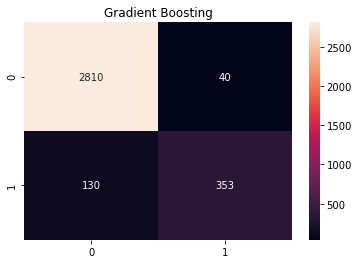

In [21]:
grad_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, gradient_boost))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);

### Support Vector Machines

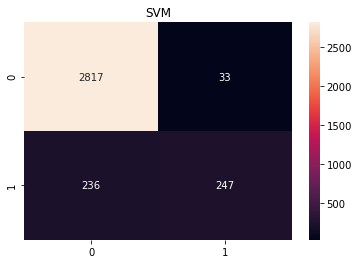

In [22]:
svm_svc_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, svc_model))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

### Random Forest

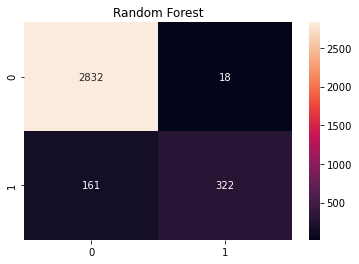

In [23]:
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, random_forest))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

### Logistic Regression

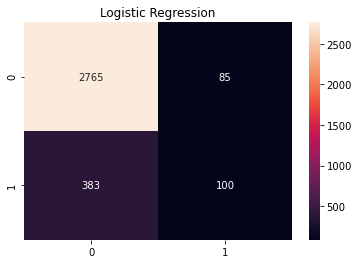

In [24]:
logistic_regression_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, logistic_regression))
sns.heatmap(logistic_regression_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

### Classification Report

In [25]:
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, gradient_boost))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svc_model))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, random_forest))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2850
           1       0.93      0.75      0.83       483

    accuracy                           0.95      3333
   macro avg       0.94      0.87      0.90      3333
weighted avg       0.95      0.95      0.95      3333


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      2850
           1       0.89      0.52      0.66       483

    accuracy                           0.92      3333
   macro avg       0.91      0.75      0.81      3333
weighted avg       0.92      0.92      0.91      3333


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      2850
           1       0.91      0.64      0.75       483

    accuracy                           0.94      3333
   macro avg       0.93      0.81     

## Final Model Selection

Gradient Boosting seems to do comparatively better for this case

In [26]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier()

[0.00236938 0.00354702 0.00051753 0.09486837 0.04617238 0.03720991
 0.12423071 0.00407181 0.16632813 0.09160236 0.00081427 0.05148363
 0.0100769  0.00111771 0.00837737 0.04359635 0.11062964 0.04008664
 0.16289992]


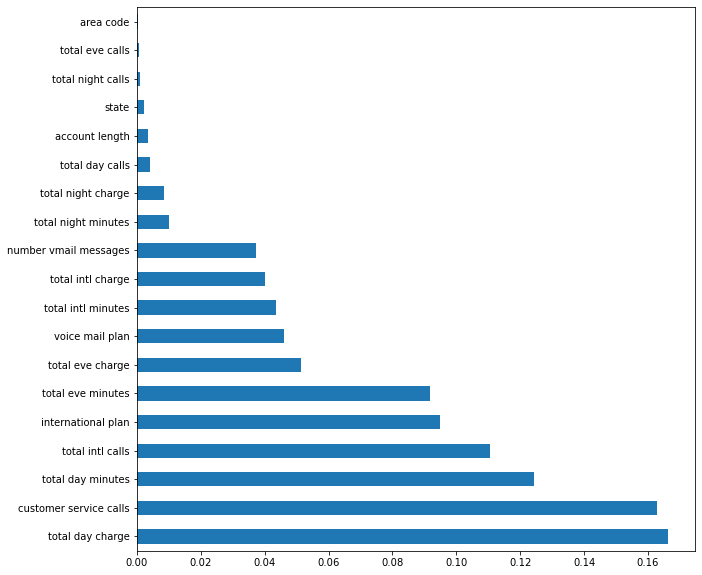

In [27]:
# Get Feature Importance from the classifier
feature_importance = gbc.feature_importances_
print (gbc.feature_importances_)
feat_importances = pd.Series(gbc.feature_importances_, index=df.columns)
feat_importances = feat_importances.nlargest(19)
feat_importances.plot(kind='barh' , figsize=(10,10)) 

## Save and Deploy model to Watson Machine Learning

In [28]:
!pip install ibm-watson-machine-learning

In [32]:
# Provide your credentials
# If your WML service is deployed in US-South use the URL https://us-south.ml.cloud.ibm.com
# To generate a new API Key go to https://cloud.ibm.com/iam/apikeys and create one

from ibm_watson_machine_learning import APIClient

wml_credentials = {
  "url": "https://zen-cpd-zen.ttacloudpakibmcluster-7c6511cbef454b73861c1e734bd972dd-0000.eu-de.containers.appdomain.cloud",
  "instance_id": "wml_local",
  "username": "admin",
  "password": "WHBSSegQm7v7hIJUIihH",
  "version": "3.5"
}

#wml_credentials = {
#                   "url": "https://us-south.ml.cloud.ibm.com",
#                   "apikey":"YOUR-API-KEY-HERE"
#                  }

client = APIClient(wml_credentials)
print(client.version)

1.0.34


Working with spaces:

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use <a href="https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas" target="_blank">Deployment Spaces Dashboard</a> to create one.

    - Click New Deployment Space
    - Create an empty space
    - Select Cloud Object Storage
    - Select Watson Machine Learning instance and press Create
    - Copy space_id and paste it below, you will find it in your (Deployment Space)-URL, it will look like this: "1234a1b-cd5e-6fg7-8hi9-11jkl2mno34p"
    
Working with projects:

    - Go to your project, you can reach it from your Cloud Pak for Data as a Service Overview Page
    - Copy project_id and paste it below, you will find it in your (Project)-URL, it will look like this: "1234a1b-cd5e-6fg7-8hi9-11jkl2mno34p"


In [33]:
# project id and space id
# both can be found in the URL
#project_id = ""
#client.set.default_project(project_id)

# deployment space
space_id = "aecbd34f-3040-409b-92f1-955f37162d44"
client.set.default_space(space_id)

# Use this cell to do any cleanup of previously created models and deployments
#client.repository.list_models()
client.deployments.list()
#client.spaces.list(limit=10)

#client.repository.delete('0f71cec9-02d8-4e37-9fff-f176914da109')
#client.deployments.delete('0f71cec9-02d8-4e37-9fff-f176914da109')

------------------------------------  ----------------------------  -----  ------------------------
GUID                                  NAME                          STATE  CREATED
2b855ce2-3dc9-41ac-9ef4-f240aec2ea6e  SPSS Churn online Deployment  ready  2020-12-28T13:35:43.035Z
3d18ecbb-f61d-4a02-8c2c-7cc85c6519de  GBC model deployment          ready  2020-12-21T16:54:54.803Z
8b0d1cbe-aef0-4ffd-b2c2-846aa8a359c1  GBC model deployment          ready  2020-12-21T16:21:03.071Z
------------------------------------  ----------------------------  -----  ------------------------


In [34]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

# store the model in WML
metadata={
    client.repository.ModelMetaNames.NAME: "GBC model Test Database",
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}
published_model = client.repository.store_model(
    model=gbc,
    meta_props=metadata,
    training_data=X, training_target=y
)


In [35]:
# new list of models
client.repository.list_models()

# get UID of our just stored model
model_uid = client.repository.get_model_uid(published_model)
print("Model id: {}".format(model_uid))

------------------------------------  -----------------------  ------------------------  -----------------
ID                                    NAME                     CREATED                   TYPE
37206f6d-7c50-4599-b963-713a00565b66  GBC model Test Database  2020-12-29T16:06:58.002Z  scikit-learn_0.23
cf991f66-a07b-47c4-a59c-8b06cc768eb6  SPSS Churn Result Table  2020-12-28T13:33:51.002Z  spss-modeler_18.2
e44d755d-0e2b-4d42-86ff-56184b1c41bc  GBC model                2020-12-21T16:20:36.002Z  scikit-learn_0.23
------------------------------------  -----------------------  ------------------------  -----------------
Model id: 37206f6d-7c50-4599-b963-713a00565b66


In [36]:
# create deployment
#created_deployment = client.deployments.create(model_uid, name="GBC model deployment")

# new list of deployments
#client.deployments.list()

# get UID of our new deployment
#deployment_uid = client.deployments.get_uid(created_deployment)
#print("Deployment id: {}".format(deployment_uid))
#print(created_deployment)


metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "GBC model deployment Database PY 37 / ScikitLearn23",
    # client.deployments.ConfigurationMetaNames.VIRTUAL: {"export_format": "coreml"},
    client.deployments.ConfigurationMetaNames.ONLINE:{}
}

created_deployment = client.deployments.create(model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '37206f6d-7c50-4599-b963-713a00565b66' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='022b964f-a50b-407e-bd61-e21d10592715'
------------------------------------------------------------------------------------------------




In [ ]:
# test your model with some test data
#created_deployment = client.deployments.create('48162ded-2fa7-4cf8-af8f-0a4a91b39a0d', meta_props=metadata)
deployment_id = '59e3f597-3abf-4a80-94b4-c777f45daaf7'

#client.deployments.get_id(created_deployment)

scoring_data = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [
        {
            'fields': ['state', 'account length', 'area code', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], 
            'values': [[2,162,415,0,0,0,70.7,108,12.02,157.5,87,13.39,154.8,82,6.97,9.1,3,2.46,4]]
        }]
}

predictions = client.deployments.score(deployment_id, scoring_data)
print("The Prediction output regarding customer churn will be displayed in this format 1 for True or 0 for False: \n ", predictions)

#use this to test model in CPD UI
# Deployment - Test (Basically change ' with ")
# {"input_data": [{"fields": ["state", "account length", "area code", "international plan", "voice mail plan", "number vmail messages", "total day minutes", "total day calls", "total day charge", "total eve minutes", "total eve calls", "total eve charge", "total night minutes", "total night calls", "total night charge", "total intl minutes", "total intl calls", "total intl charge", "customer service calls"],"values": [[2,162,415,0,0,0,70.7,108,12.02,157.5,87,13.39,154.8,82,6.97,9.1,3,2.46,4]]}]}

## Acknowledgement

The approach and code fragments have been adopted from the nootebook on Kaggle by Sandip Datta (https://www.kaggle.com/sandipdatta). 
The full original notebook can be viewed here: https://www.kaggle.com/sandipdatta/customer-churn-analysis#